In [1]:
# datasets/childrenBook/childrenBook_with_model_outcomes.json
# datasets/bookSumm/book_summ_with_model_outcomes.json
# datasets/VIST/test_with_model_outcomes.json

In [1]:
import json 
import os
from transformers import AutoModelWithLMHead, AutoTokenizer,VisionEncoderDecoderModel, ViTFeatureExtractor,ViTImageProcessor

In [2]:
from PIL import Image
import torch
from torchvision.io import read_image

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from nltk.corpus import stopwords

excl_words = stopwords.words('english') + [".",",","-","!","?"]

In [5]:
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## A. Load original data used for training

### VIST 

In [7]:
ann = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/annotations")
labels = open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/annotations/StoriesFin.json")
labels = json.load(labels)

In [33]:
vist_total_tokens = []
sentence_length = 0
c = 0
tokens_per_story = []
for s in labels:
    per_story = []
    for t in labels[s]['text']:
        toks = t.split(' ')
        sentence_length += len(toks)
        vist_total_tokens += toks
        per_story += toks
        c += 1
    tokens_per_story.append(len(set(per_story)))


In [34]:
len(labels.keys())

5149

In [35]:
len(set(vist_total_tokens))

11266

In [36]:
sentence_length/c

11.341852786948921

In [37]:
sum(tokens_per_story)/len(tokens_per_story)

39.46824626140998

### children book

In [27]:
c_stories = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/labels2")

In [28]:
c_test = {}
org_im_path = "/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/images2"
org_lab_path = "/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/labels2"
for c in c_stories:
    c_test[c] = {}
    c_test[c]["image_paths"] = []
    c_test[c]["text"] = []
    imgs = sorted(os.listdir(f"{org_im_path}/{c}"))
    imgs = [i for i in imgs if '.jpg' in i]
    for im in imgs:
        lab = im.replace('.jpg','.txt')
        sen = open(f"{org_lab_path}/{c}/{lab}").read()
        c_test[c]["text"].append(sen)
        c_test[c]["image_paths"].append(org_im_path + f'/{c}/' + im)

In [29]:
c_total_tokens = []
sentence_length = 0
c = 0
tokens_per_story = []
for s in c_test:
    per_story = []
    for t in c_test[s]['text']:
        toks = t.split(' ')
        sentence_length += len(toks)
        c_total_tokens += toks
        per_story += toks
        c += 1
    tokens_per_story.append(len(set(per_story)))


In [30]:
print(len(set(c_total_tokens)))
print(sentence_length/c)
print(sum(tokens_per_story)/len(tokens_per_story))

1555
19.8
73.05555555555556


In [31]:
len(c_test.keys())

36

## Book Summ

In [8]:
b_stories = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/labels")
b_test = {}
org_im_path = "/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images"
org_lab_path = "/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/labels"
for c in b_stories:
    b_test[c] = {}
    b_test[c]["image_paths"] = []
    b_test[c]["text"] = []
    imgs = sorted(os.listdir(f"{org_im_path}/{c}"))
    imgs = [i for i in imgs if '.jpg' in i]
    for im in imgs:
        lab = im.replace('.jpg','.txt')
        sen = open(f"{org_lab_path}/{c}/{lab}").read()
        b_test[c]["text"].append(sen)
        b_test[c]["image_paths"].append(org_im_path + f'/{c}/' + im)

In [9]:
len(b_test.keys())

70

In [24]:
b_total_tokens = []
sentence_length = 0
c = 0
tokens_per_story = []
for s in b_test:
    per_story = []
    for t in b_test[s]['text']:
        toks = t.split('. ')
        for t in toks:
            t = t.split(' ')
            sentence_length += len(t)
            b_total_tokens += t
            per_story += t
            c += 1
    tokens_per_story.append(len(set(per_story)))


In [26]:
print(len(set(b_total_tokens)))
print(sentence_length/c)
print(sum(tokens_per_story)/len(tokens_per_story))

6907
20.073318632855568
261.6142857142857


In [38]:
len(set(vist_total_tokens).intersection(set(c_total_tokens)))/len(set(c_total_tokens))

0.5620578778135048

In [39]:
len(set(vist_total_tokens).intersection(set(b_total_tokens)))/len(set(b_total_tokens))

0.3916316780078182

## B. After model training

In [17]:
max_length = 100
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(model, image_paths):
    images = []
    for image_path in image_paths:

        try:
            i_image = Image.open(image_path)
        except:
            return None
            
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
    
        images.append(i_image)
    
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    
    return preds

## VIST

In [61]:
# Opening JSON file 
f = open('/home/jay.je/IMspiredStoryTelling/datasets/VIST/test_with_model_outcomes.json',) 
vist_data = json.load(f)

In [62]:
vist_data

{'story_45531_0': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741625.jpeg',
  'text': 'i was so excited to be heading to the crafts fair .',
  'output': 'a woman standing on a sidewalk next to a yellow fire hydrant'},
 'story_45531_1': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741640.jpeg',
  'text': 'when i arrived i saw a great booth with a variety of great crafts .',
  'target_intersect': ['crafts'],
  'output': 'a table filled with lots of food on top of a table',
  'output_intersect': [],
  'target_unique_len': 6,
  'target_pct_overlap': 0.16666666666666666,
  'output_unique_len': 5,
  'output_pct_overlap': 0.0},
 'story_45531_2': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741639.jpeg',
  'text': "i stopped at chatted at my friend [female] 's booth for a bit .",
  'target_intersect': ['booth'],
  'output': 'a man standing next to a woman in front of a table full of food',
  'outpu

In [79]:
vist_data

{'story_45531_0': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741625.jpeg',
  'text': 'i was so excited to be heading to the crafts fair .',
  'output': 'a woman standing on a sidewalk next to a yellow fire hydrant'},
 'story_45531_1': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741640.jpeg',
  'text': 'when i arrived i saw a great booth with a variety of great crafts .',
  'target_intersect': ['crafts'],
  'output': 'a table filled with lots of food on top of a table',
  'output_intersect': [],
  'target_unique_len': 6,
  'target_pct_overlap': 0.16666666666666666,
  'output_unique_len': 5,
  'output_pct_overlap': 0.0},
 'story_45531_2': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741639.jpeg',
  'text': "i stopped at chatted at my friend [female] 's booth for a bit .",
  'target_intersect': ['booth'],
  'output': 'a man standing next to a woman in front of a table full of food',
  'outpu

In [91]:
vist_before_total_tokens = []
sentence_length = 0
c = 0
tokens_per_story = []
unique_tokens_per_story = []
for s in vist_data:
    if 'output' in vist_data[s]:
        output = vist_data[s]['output']
        toks = output.split(' ')
        sentence_length += len(toks)
        vist_before_total_tokens += toks
        
        unique_tokens_per_story.append(len(set(toks)))
        tokens_per_story.append(len(toks))
        
        c += 1


In [87]:
print(len(set(vist_before_total_tokens)))
print(sentence_length/c)

476
10.162212554381604


In [105]:
print(sum(tokens_per_story)/len(tokens_per_story))

10.162212554381604


In [106]:
print(sum(unique_tokens_per_story)/len(unique_tokens_per_story))

8.413300186451211


### B.i After VIST fine-tuning

In [71]:
def get_token_stats(data, model_output_col):

    before_total_tokens = []
    sentence_length = 0
    c = 0
    tokens_per_story = []
    unique_tokens_per_story = []
    for s in data:
        if model_output_col in data[s]:
            output = data[s][model_output_col]
            if len(output) > 0:
                toks = output[0].split(' ')
                sentence_length += len(toks)
                before_total_tokens += toks
                
                unique_tokens_per_story.append(len(set(toks)))
                tokens_per_story.append(len(toks))
                
                c += 1

    print("unique number of tokens: ", len(set(before_total_tokens)))
    print("average sentence length: ", sentence_length/c)
    print("avg. unique tokens per story segment: ", sum(unique_tokens_per_story)/len(unique_tokens_per_story))

In [12]:
# Load the model

vist_model = VisionEncoderDecoderModel.from_pretrained('./finalModels/model_epoch1_img_5000_VIST/')

In [15]:
vist_model.to("cuda")

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [31]:
vist_model.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [16]:
ann_test = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/annotations")
labels_test = open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/annotations/TestStoriesFin.json")
labels_test = json.load(labels_test)
test = {}
for s in labels_test:
    for idx, im in enumerate(labels_test[s]['img_ids']):
        image_path = f"/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/{im}.jpeg"
        test[f'story_{s}_{idx}'] = {}
        test[f'story_{s}_{idx}']['image_path'] = image_path
        test[f'story_{s}_{idx}']['text'] = labels_test[s]['text'][idx]

In [19]:
c = 0
for s in test:
    img_path = test[s]['image_path']
    target = test[s]['text']
    test[s]['after_finetune'] = []
    if os.path.exists(img_path) and 'jpeg' in img_path:

        output = predict_step(vist_model, [img_path])
        
        if output != None:
            test[s]['after_finetune'].append(output[0])
    c += 1

    if c % 500 == 0:
        print(f"Processed {c} samples")

In [67]:
test['story_45544_1']

{'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/21728852.jpeg',
 'text': 'electronic seals dazzled the attendees .',
 'after_finetune': ['it was a great day for us to be able to use the nintendo wii.']}

In [72]:
get_token_stats(test, 'after_finetune')

unique number of tokens:  439
average sentence length:  10.969213853765805
avg. unique tokens per story segment:  8.574491478834524


In [74]:
# vist_model.to("cpu")

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

### B.ii After VIST + children book fine-tuning

In [5]:
f = open('/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/childrenBook_with_model_outcomes.json')
vc_data = json.load(f)

In [7]:
vc_data

{'story_12_0': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/images2/story_12/0.jpg',
  'text': 'dory is having a boring family holiday in a small sea-side town in england',
  'output': 'a black and white photo of a white bird'},
 'story_12_1': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/images2/story_12/1.jpg',
  'text': 'her dorky younger sister, gracie, has become obsessed with letter-boxing',
  'target_intersect': [],
  'target_unique_len': 7,
  'target_pct_overlap': 0.0,
  'output': 'a painting of a grassy area with a clock on it',
  'output_intersect': [],
  'output_unique_len': 4,
  'output_pct_overlap': 0.0},
 'story_12_2': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/images2/story_12/2.jpg',
  'text': 'while reluctantly out on one of these hunts dory stumbles across a very old letter-box, one that contains a note from the late 1800s, and one with the magical power to pull her back to that time',
 

In [73]:
vistc_model = VisionEncoderDecoderModel.from_pretrained('./finalModels/model_epoch1_img_5000_VIST_childrenbook/')

In [75]:
vistc_model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [33]:
c = 0
for s in test:
    img_path = test[s]['image_path']
    target = test[s]['text']
    
    if 'after_finetune' in test[s] and 'after_finetune_vc' not in test[s]:
        test[s]['after_finetune_vc'] = []
        if os.path.exists(img_path) and 'jpeg' in img_path:
    
            output = predict_step(vistc_model, [img_path])
            
            if output != None:
                test[s]['after_finetune_vc'].append(output[0])
        c += 1

    if c % 500 == 0 and c != 0:
        # print(f"Processed {c} samples")

In [80]:
get_token_stats(test, 'after_finetune_vc')

unique number of tokens:  674
average sentence length:  75.10174880763115
avg. unique tokens per story segment:  16.241653418124006


In [82]:
# vistc_model.to("cpu")

### Imag eprompt

In [46]:
f = open('/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/chatGPTOutput_2.txt', 'r')
child_gpt = json.load(f)

In [54]:
img_len = 0
c = 0
for i in child_gpt:
    for k in child_gpt[i]:
        print(child_gpt[i][k]['img_prompt'])
        img_len += len(child_gpt[i][k]['img_prompt'].split(' '))
        c += 1

Offering basket. in surrealism style
Village. in surrealism style
Baby bottle. in surrealism style
Warning sign. in surrealism style
Birthday calendar. in surrealism style
Journal with a picture of Bennett at the new school.. in minimalism style
Empty desk with a note from Bennett pretending not to know Anna.. in minimalism style
Medallion that Bennett holds when saving Anna's life.. in minimalism style
Calendar showing their birth dates and age difference.. in minimalism style
Book cover with a mysterious and captivating illustration.. in minimalism style
Olympic Swim Cap. in black and white photo style
Lonely Diary. in black and white photo style
Coaching Whistle. in black and white photo style
Comedy Ticket. in black and white photo style
Coming-of-Age Novel. in black and white photo style
Nightlight - Provides comfort to Robyn in her fear.. in 3D illustration style
Diary - Chronicles Robyn's worries and fears after her father's attack.. in 3D illustration style
Protest sign - Indic

In [64]:
child_gpt['0']

{'0': {'org': 'every year, the evil protectorate offers a baby to the evil witch in the forest to ensure their village’s safety',
  'img_prompt': 'Offering basket. in surrealism style'},
 '1': {'org': 'yet, unknown to them, the witch is xan, the plump and knowledgeable protector of the babies that she takes to the neighbouring village to be raised as special children, fed on starlight and destined to do wonderful things',
  'img_prompt': 'Village. in surrealism style'},
 '2': {'org': 'yet, one day, xan feeds one baby the moon by mistake and fills her with a huge amount of magic',
  'img_prompt': 'Baby bottle. in surrealism style'},
 '3': {'org': 'a dangerous amount, as it turns out',
  'img_prompt': 'Warning sign. in surrealism style'},
 '4': {'org': 'but nothing is straightforward, and when luna turns 13, everything will change',
  'img_prompt': 'Birthday calendar. in surrealism style'}}

In [55]:
img_len/c

10.32

In [56]:
f = open('/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/chatGPTOutput_BookSumm.txt', 'r')
book_gpt = json.load(f)

In [58]:
img_len = 0
c = 0
for i in book_gpt:
    for k in book_gpt[i]:
        img_len += len(book_gpt[i][k]['img_prompt'].split(' '))
        c += 1

In [59]:
img_len/c

9.185294117647059

In [62]:
book_gpt['10']

{'0': {'org': "the king and queen of hearts were seated on their throne when they arrived, with a great crowd assembled about them--all sorts of little birds and beasts, as well as the whole pack of cards: the knave was standing before them, in chains, with a soldier on each side to guard him; and near the king was the white rabbit, with a trumpet in one hand, and a scroll of parchment in the other. in the very middle of the court was a table, with a large dish of tarts upon it: they looked so good, that it made alice quite hungry to look at them--'i wish they'd get the trial done,' she thought, 'and hand round the refreshments!' but there seemed to be no chance of this, so she began looking at everything about her, to pass away the time.",
  'img_prompt': 'large dish of tarts, in black and white photo style'},
 '1': {'org': "alice had never been in a court of justice before, but she had read about them in books, and she was quite pleased to find that she knew the name of nearly everyt

### B.iii After VIST + book summ

In [6]:
f = open('/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/book_summ_with_model_outcomes.json')
vb_data = json.load(f)

In [84]:
vistb_model = VisionEncoderDecoderModel.from_pretrained('./finalModels/model_epoch0_img_5000_VIST_with_bookSumm/')

In [86]:
vistb_model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [42]:
c = 0
for s in test:
    img_path = test[s]['image_path']
    target = test[s]['text']
    test[s]['after_finetune_vb'] = []
    if os.path.exists(img_path) and 'jpeg' in img_path:

        if 'after_finetune' in test[s]:
            output = predict_step(vistb_model, [img_path])
            
            if output != None:
                test[s]['after_finetune_vb'].append(output[0])
            
            c += 1

    if c % 500 == 0:
        # print(f"Processed {c} samples")

In [89]:
test

{'story_45531_0': {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741625.jpeg',
  'text': 'i was so excited to be heading to the crafts fair .',
  'after_finetune': ['there was a lot of fun to be had.'],
  'after_finetune_vc': ['there is a girl who is walking down the street with her hand on her shoulder, and she is trying to grab a piece of paper out of her pocket, and she is also trying to grab a piece of paper out of her pocket, and she is also trying to grab a piece of paper out of her pocket, and she is also trying to grab a piece of paper out of her pocket, and she is also trying to grab a piece of paper out of her pocket, and she is'],
  'after_finetune_vb': ['the young man was walking down the street with his feet on the ground and his hands on his hips, and his feet on the ground, and his feet on the ground, and his feet on the ground, and his feet on the ground, and his feet on the ground, and his feet on the ground, and his feet on the ground, an

In [90]:
get_token_stats(test, 'after_finetune_vb')

unique number of tokens:  319
average sentence length:  87.32596685082873
avg. unique tokens per story segment:  14.298342541436464


In [91]:
fin = json.dumps(test, indent=4)
with open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/test_with_finetune_model_outcomes.json", "w") as f:
    f.write(fin)
    f.close()

## If sentences are now more related to each other?

In [122]:
labels = open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/test_with_finetune_model_outcomes.json")
test = json.load(labels)

In [141]:
def check_sentence_connect(data_d, model_outcome_col):

    for s in data_d:
        story_num = s.split('_')[1]
        
        prev_target = None
        prev_gen = None
        
        for i in range(5):
            key = f'story_{story_num}_{i}'
            # img_path = data_d[f'story_{story_num}_{i}']['image_path']
            # target = data_d[f'story_{story_num}_{i}']['text'].split(' ')
            
            if model_outcome_col in data_d[key]:                
                output = data_d[key][model_outcome_col]
                if prev_gen != None and len(output)>0:
                    s1=set([i for i in prev_gen if i not in excl_words])
                    s2=set([i for i in output[0].split(' ') if i not in excl_words])                    
                    intersect_words = s1.intersection(s2)
                    data_d[f'story_{story_num}_{i}'][f'{model_outcome_col}_output_intersect'] = intersect_words
                    data_d[f'story_{story_num}_{i}'][f'{model_outcome_col}_output_unique_len'] = len(s2)

                    if len(s2) > 0:
                        data_d[f'story_{story_num}_{i}'][f'{model_outcome_col}_output_pct_overlap'] = len(intersect_words)/len(s2)

                if len(output) > 0:
                    prev_gen = output[0].split(' ')
    

In [142]:
check_sentence_connect(test, 'after_finetune')

In [144]:
check_sentence_connect(test, 'after_finetune_vc')

In [145]:
check_sentence_connect(test, 'after_finetune_vb')

In [146]:
test['story_45531_2']

{'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/1741639.jpeg',
 'text': "i stopped at chatted at my friend [female] 's booth for a bit .",
 'after_finetune': ['[male] and [female] were in the kitchen preparing food for us to eat. [male] and [female] were in the kitchen preparing food for us to eat.'],
 'after_finetune_vc': ['we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and we are getting ready to go to the party, and'],
 'after_finetune_vb': ['i am unable to see the image above, but i am unable to see the image above, and i am unable to see the image above, and i am unable to see the image above, and i am unable to see the image above, and i am unable t

In [147]:
def get_connected_stats(data_d, model_outcome_col):

    avg = []
    target_words_denom = 0 
    target_words_num = 0
    
    model_words_denom = 0 
    model_words_num = 0

    c=0
    for i in data_d:
        if f'{model_outcome_col}_output_pct_overlap' in data_d[i] and f'{model_outcome_col}_output_intersect' in data_d[i]:
            avg.append(data_d[i][f'{model_outcome_col}_output_pct_overlap'])
            model_words_num += len(data_d[i][f'{model_outcome_col}_output_intersect'])
            model_words_denom += data_d[i][f'{model_outcome_col}_output_unique_len']
        else:
            c+=1

    print("Average % overlap %: ", sum(avg)/len(avg))
    print("Overall prediction overlap: ", model_words_num/model_words_denom, model_words_num, model_words_denom)
    print(f"skipped {c}")
    

In [149]:
get_connected_stats(test, 'after_finetune')

Average % overlap %:  0.8791427941824592
Overall prediction overlap:  0.904151811385854 39308 43475
skipped 2269


In [150]:
get_connected_stats(test, 'after_finetune_vc')
get_connected_stats(test, 'after_finetune_vb')

Average % overlap %:  0.17463444339599593
Overall prediction overlap:  0.14031620553359683 568 4048
skipped 10804
Average % overlap %:  0.2875767905969248
Overall prediction overlap:  0.2583233052547132 644 2493
skipped 10898


## Get images / text output example!

In [152]:
test['story_45551_0']

{'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/2485114971.jpeg',
 'text': 'my daughter had her nails painted .',
 'after_finetune': ['we had a lot of fun.'],
 'after_finetune_vc': ['when she got her hair cut, she had to go to the doctor to get her hair cut, which she had to do, and she had to go to the dentist to get her hair cut, which she had to do, and she had to do, and she had to do, and she had to do, and she had to do, and she had to do, and she had to do, and she had to do, and she had to do, and she had to do'],
 'after_finetune_vb': ['i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here. i am unable to see what is going on here']}

In [175]:
list(test.keys())[210]

'story_45602_0'

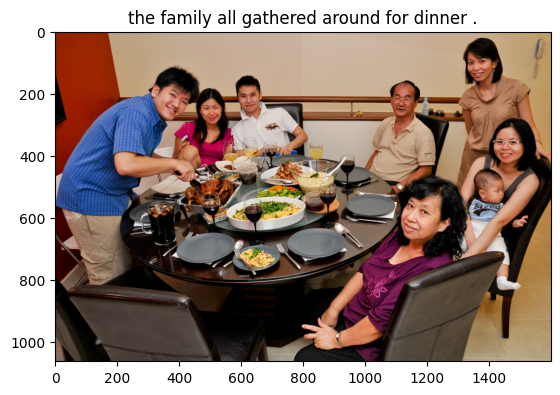

['we had a great time at the party.']
['everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and everyone is having a great time at the party, and']
['i am not sure if this is a good thing or not, but i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is']


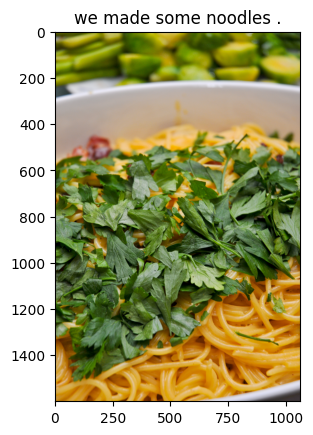

['the meal was prepared and ready to be eaten.']
['sliced up broccoli, tomatoes, and other vegetables are in a bowl of pasta and pasta sauce, with a lot of cheese and other ingredients in the bowl, as well as other ingredients in the bowl, as well as other ingredients in the bowl, as well as other ingredients in the bowl, as well as other ingredients in the bowl, as well as other ingredients in the bowl, as well as other ingredients in the bowl, as well as other ingredients in the bowl, as well as']
['i am not sure if this is a good thing or a bad thing, but it is a good thing. i am not sure if this is a good thing or a bad thing. i am not sure if this is a good thing or a bad thing. i am not sure if this is a good thing or a bad thing. i am not sure if this is a good thing or a bad thing. i am not sure if this is a good thing or a bad thing. i am']


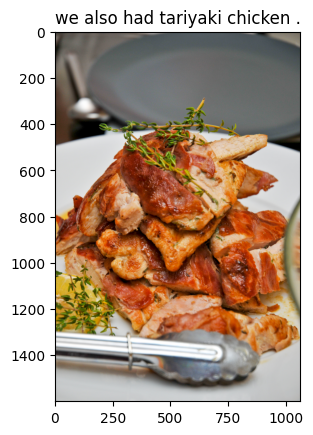

['the meal was prepared and ready to be eaten.']
['sliced meat and vegetables on a white plate with a knife and fork on the table, and a glass of wine on the side of the table, along with a plate of food, and a glass of water, along with a plate of food, and a plate of food, and a plate of food, and a plate of food, and a plate of food, and a plate of food, and a plate of food, and a plate of food, and a plate of food,']
['the meal was prepared and ready to be eaten.']


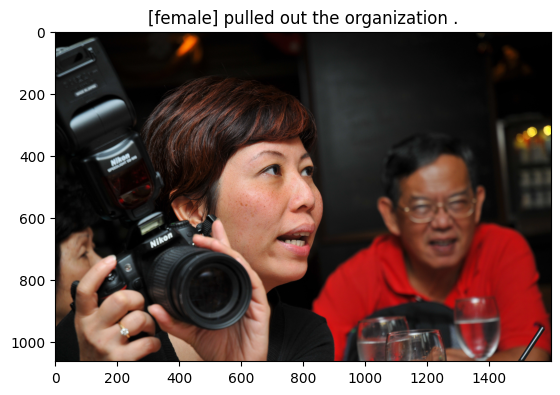

['[male] and [female] were having a great time.']
['everyone is having a great time at the party, and everyone is having a great time too, and everyone is having a great time too, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time, and everyone is having a great time']
['i am not sure if this is a good thing or not, but i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is a good thing, and i am sure it is']


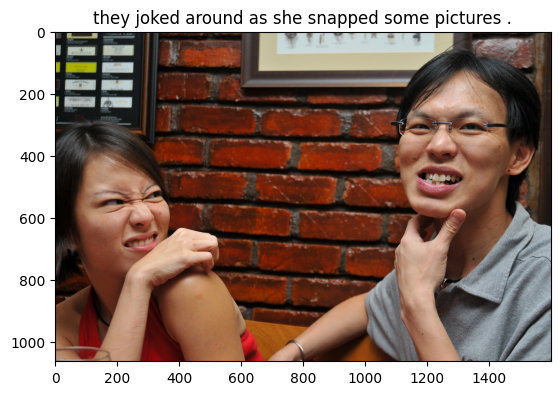

['female friends having a good time.']
['female friends, one of whom is a woman, are having a conversation on the phone, and one of whom is a man, and one of whom is a woman, are also having a conversation on the phone, and one of whom is a man, and one of whom is a woman, are also having a conversation on the phone, and one of whom is a man, and one of whom is a woman, are also having a conversation on the phone, and one of whom is a']
['one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the girls is talking to the other girl, and one of the']


In [176]:
story_num = '45602'
for i in range(5):
    img = Image.open(test[f'story_{story_num}_{i}']['image_path'])
    if img.mode != "RGB":
            img = img.convert(mode="RGB")
    
    plt.imshow(np.array(img))
    plt.title(test[f'story_{story_num}_{i}']['text'])
    plt.show()
    print(test[f'story_{story_num}_{i}']['after_finetune'])
    print(test[f'story_{story_num}_{i}']['after_finetune_vc'])
    print(test[f'story_{story_num}_{i}']['after_finetune_vb'])
    